In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
last_row = session.query(measurement).order_by(measurement.date.desc()).first()
last_row.__dict__['date']

'2017-08-23'

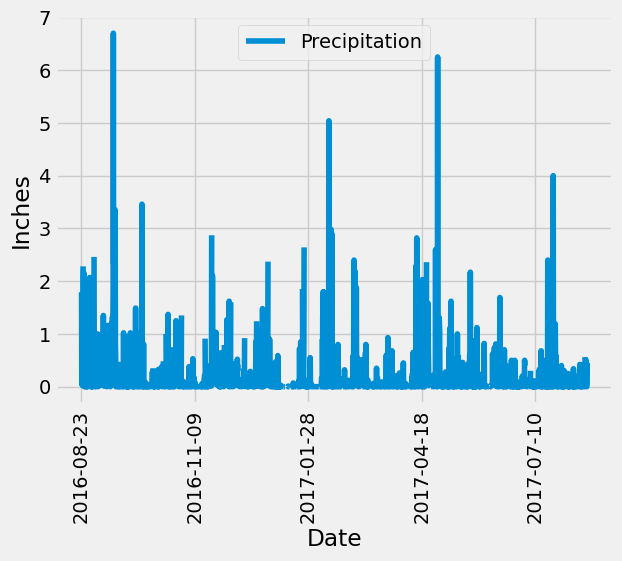

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# convert datetime to string: use strptime 
# strptime = string parse time -> converts string to datetime
# strftime = string format time -> converts datetime to string
last_date = last_row.__dict__['date']
last_year_date = (dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days = 365)).strftime("%Y-%m-%d") # reconverts the whole string conversion back to formatted datetime


# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date. This is because there are multiple data points for the same date
# I checked by using precip_df.groupby('Date').count()
precip_df.set_index('Date', inplace = True)
precip_df = precip_df.sort_index()


# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()

plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation = 90)
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station.station).count()
station_count

9

In [37]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# I used most_active[0][0] just so it queries the first one regardless if we know what the actual station is or not
# alternatively, if it doesn't matter, then we can just filter by the actual station string if we know what it is
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == most_active[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

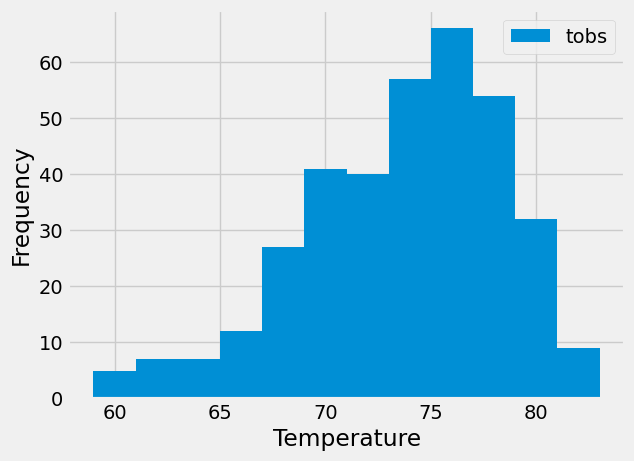

In [127]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# find the last date of the most active station
most_active_last_date = session.query(measurement).filter(measurement.station == most_active[0][0]).order_by(measurement.date.desc()).first().__dict__['date']


# find 1 year prior
# strptime = string parse time -> converts string to datetime
# strftime = string format time -> converts datetime to string
most_active_one_year_ago = (dt.datetime.strptime(most_active_last_date, "%Y-%m-%d") - dt.timedelta(days = 365)).strftime("%Y-%m-%d")

# collect the previous one year's data
most_active_last_year_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= most_active_one_year_ago).\
    filter(measurement.station == most_active[0][0]).all()
most_active_last_year_data
# convert data into df
most_active_df = pd.DataFrame(most_active_last_year_data, columns = ['Date', 'Temperature'])
most_active_df.set_index('Temperature')


# plot
most_active_df.plot(kind='hist', bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()


# Close Session

In [128]:
# Close Session
session.close()